In [1]:
# Data convert for the original simulation test. 
# # convert_trace.py
def convert_trace_file(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line_num, line in enumerate(infile, 1):
            line = line.strip()
            if not line:  # Skip empty lines
                continue
                
            parts = line.split()
            if len(parts) < 4:
                print(f"Warning: Line {line_num} has insufficient columns: {line}")
                continue
            
            # Extract required fields
            timestamp = parts[0]          # Column 0: timestamp
            operation_raw = parts[1]      # Column 1: WS/RS
            file_id = parts[2]           # Column 2: file_id  
            file_size = parts[3]         # Column 3: file_size
            
            # Convert operation type: WS -> W, RS -> R
            if operation_raw == 'WS':
                operation_type = 'write'
            elif operation_raw == 'RS':
                operation_type = 'read'
            else:
                print(f"Warning: Unknown operation type '{operation_raw}' on line {line_num}")
                operation_type = operation_raw  # Keep original if unknown
            
            # Output in required format: timestamp,file_id,file_size,operation_type
            outfile.write(f"{timestamp},{file_id},{file_size},{operation_type}\n")
    
    print(f"Conversion completed! Output saved to {output_file}")

if __name__ == "__main__":
    convert_trace_file('wdev_3.revised', 'converted_trace.txt')

Conversion completed! Output saved to converted_trace.txt


In [5]:
# Data convert for the RL data placement simulation test. 
def convert_trace_file(input_file, output_file):
    """
    Convert a storage trace to a CSV with:
    operation_type, LBA, block_size, inter_arrival, service_time, idle_time
    """
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line_num, line in enumerate(infile, 1):
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            # Expecting at least 8 columns based on your description
            if len(parts) < 8:
                print(f"Warning: line {line_num} has insufficient columns: {line}")
                continue

            # parts mapping based on your dataset:
            # 0: timestamp
            # 1: WS/RS
            # 2: LBA
            # 3: block_size
            # 4: seq/rand   (we skip this)
            # 5: inter-arrival time
            # 6: service time
            # 7: idle time

            op_raw = parts[1]
            lba = parts[2]
            block_size = parts[3]
            inter_arrival = parts[5]
            service_time = parts[6]
            idle_time = parts[7]

            # normalize operation
            if op_raw == "WS":
                op = "write"
            elif op_raw == "RS":
                op = "read"
            else:
                print(f"Warning: unknown operation '{op_raw}' on line {line_num}")
                op = op_raw  # keep original

            # write in CSV format
            # operation, LBA, block_size, inter_arrival, service_time, idle_time
            outfile.write(f"{op},{lba},{block_size},{inter_arrival},{service_time},{idle_time}\n")

    print(f"Conversion completed. Output saved to {output_file}")


if __name__ == "__main__":
    convert_trace_file("wdev_3.revised", "converted_trace.csv")


Conversion completed. Output saved to converted_trace.csv


Loaded 680 lines from wdev_3.revised
   timestamp  op      lba  size_blocks pattern  inter_arrival   latency  \
0   0.000004  WS  1540175            8     seq       0.000012  0.000049   
1   0.000064  WS  1540167            8    rand       5.002759  0.000071   
2   0.010229  WS  1572951            8    rand       2.922415  0.000031   
3   0.020356  WS  1572991           16    rand       2.078673  0.000051   
4   0.030497  WS  1541335            8    rand       0.000011  0.000018   

       idle  size_bytes  size_KB  latency_us  inter_from_ts  
0  0.000000        4096      4.0      48.534       0.000000  
1  5.002594        4096      4.0      71.110       0.000061  
2  2.922288        4096      4.0      31.269       0.010165  
3  2.078532        8192      8.0      51.254       0.010127  
4  0.000000        4096      4.0      18.199       0.010141  


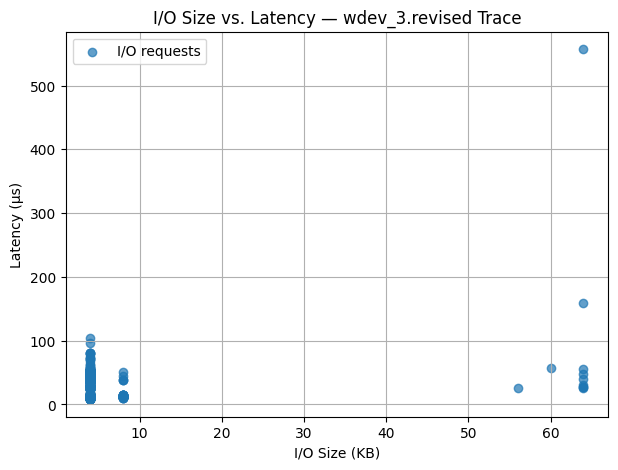

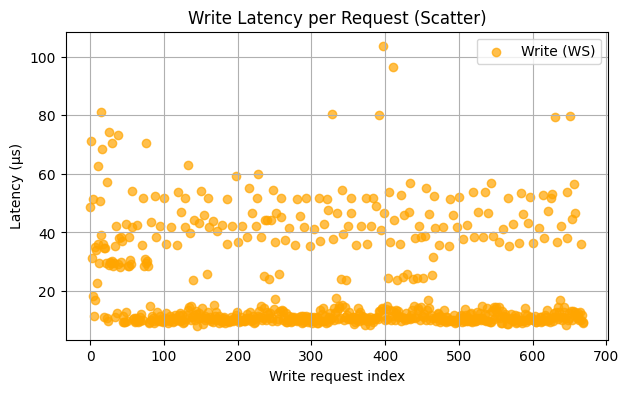

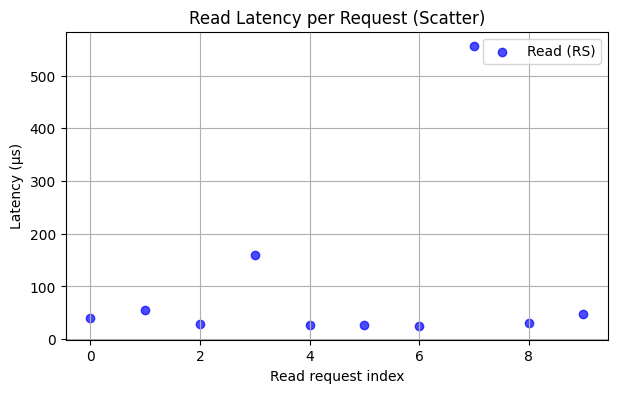

In [6]:
# MSRC I/O Trace Analysis
# -------------------------------------------------------
# Reads the wdev_3.revised file, extracts WS/RS, data size, and latency,
# and plots:
#   1) I/O size vs latency
#   2) Write latency vs request index (scatter)
#   3) Read latency vs request index (scatter)
# -------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

# === Load your trace file ===
trace_path = Path("wdev_3.revised")

if not trace_path.exists():
    raise FileNotFoundError("Trace file 'wdev_3.revised' not found in the current directory.")

# Read all lines
with open(trace_path, "r") as f:
    lines = [ln.strip() for ln in f.readlines() if ln.strip()]

print(f"Loaded {len(lines)} lines from {trace_path}")

# === Parse the data ===
rows = []
for line in lines:
    parts = line.split()
    if len(parts) < 8:
        continue
    ts = float(parts[0])
    op = parts[1]               # WS / RS
    lba = int(parts[2])
    size_blocks = int(parts[3])
    pattern = parts[4]
    inter_arrival = float(parts[5])
    service_time = float(parts[6])  # this is latency
    idle = float(parts[7])
    rows.append({
        "timestamp": ts,
        "op": op,
        "lba": lba,
        "size_blocks": size_blocks,
        "pattern": pattern,
        "inter_arrival": inter_arrival,
        "latency": service_time,
        "idle": idle
    })

# Convert to DataFrame
df = pd.DataFrame(rows).sort_values("timestamp").reset_index(drop=True)

# === Add derived metrics ===
SECTOR_SIZE = 512  # adjust if using 4K sectors
df["size_bytes"] = df["size_blocks"] * SECTOR_SIZE
df["size_KB"] = df["size_bytes"] / 1024
df["latency_us"] = df["latency"] * 1e6
df["inter_from_ts"] = df["timestamp"].diff().fillna(0.0)

print(df.head())

# -------------------------------------------------------
# Plot 1: data size vs latency
# -------------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(df["size_KB"], df["latency_us"], alpha=0.7, label="I/O requests")
plt.xlabel("I/O Size (KB)")
plt.ylabel("Latency (µs)")
plt.title("I/O Size vs. Latency — wdev_3.revised Trace")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------------------------------
# Plot 2: write latency vs request index (scatter)
# -------------------------------------------------------
df_w = df[df["op"] == "WS"].reset_index(drop=True)
plt.figure(figsize=(7,4))
plt.scatter(df_w.index, df_w["latency_us"], color="orange", alpha=0.7, label="Write (WS)")
plt.xlabel("Write request index")
plt.ylabel("Latency (µs)")
plt.title("Write Latency per Request (Scatter)")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------------------------------
# Plot 3: read latency vs request index (scatter)
# -------------------------------------------------------
df_r = df[df["op"] == "RS"].reset_index(drop=True)
if not df_r.empty:
    plt.figure(figsize=(7,4))
    plt.scatter(df_r.index, df_r["latency_us"], color="blue", alpha=0.7, label="Read (RS)")
    plt.xlabel("Read request index")
    plt.ylabel("Latency (µs)")
    plt.title("Read Latency per Request (Scatter)")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No RS (read) requests found in this trace.")


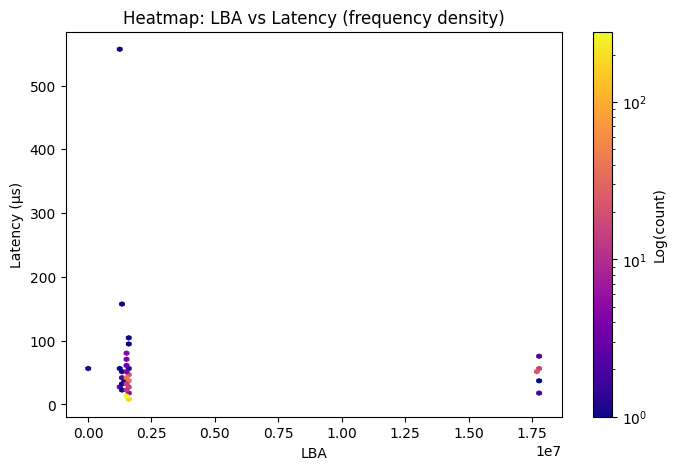

In [4]:
plt.figure(figsize=(8,5))
plt.hexbin(
    df["lba"], 
    df["latency_us"], 
    gridsize=100,       # controls resolution (smaller = more detailed)
    cmap="plasma", 
    bins="log"          # color scale by log(count)
)
plt.xlabel("LBA")
plt.ylabel("Latency (µs)")
plt.title("Heatmap: LBA vs Latency (frequency density)")
cb = plt.colorbar()
cb.set_label("Log(count)")
plt.show()
